## Extracting Rayleigh wave from seismometers
We use seimic catalogs and seismometer data downloaded using ObsPy to extract Rayleigh wave waveforms. These waveforms can be scaled and added to balloon pressure waveforms to build realistic synthetic data to train an anomaly detector.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from obspy.core.utcdatetime import UTCDateTime
import importlib
import matplotlib.pyplot as plt
import os

import obspy
from obspy.clients.fdsn import Client

## US data + Alaskan quakes

In [224]:
c_event = Client("USGS")

## Region
starttime = UTCDateTime("2016-01-01")
endtime = UTCDateTime("2023-01-01")
minmagnitude = 6.
maxdepth = 50
region = dict(minlatitude=52, maxlatitude=73, minlongitude=-170, maxlongitude=-130) # Alaska

# Get the event information. The temporal and magnitude constraints make it unique
events = c_event.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmagnitude, maxdepth=maxdepth, orderby='magnitude', **region)
print(events)

19 Event(s) in Catalog:
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2  mww | manual
2018-01-23T09:31:40.890000Z | +56.004, -149.166 | 7.9  mww | manual
...
2018-08-12T21:15:00.999000Z | +69.523, -144.339 | 6.0  mw | manual
2018-12-31T02:35:37.670000Z | +54.427, -161.513 | 6.0  mww | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [226]:
inv = Client('IRIS').get_stations(network="TA", station="*", channel="BDF", starttime=UTCDateTime('2018-01-01'), endtime=UTCDateTime('2018-01-01') + 3600, level="response")
inv.select(**region)

In [230]:
print(inv.select(**region, starttime=starttime))

Inventory created at 2023-05-11T11:38:18.152500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TA
		Stations (192):
			TA.A19K (Wainwright, AK, USA)
			TA.A21K (Barrow, AK, USA)
			TA.A22K (Sinclair Lake, AK, USA)
			TA.B18K (Kokolik River, AK, USA)
			TA.B20K (Meade River, AK, USA)
			TA.B21K (Ikpikpuk River, AK, USA)
			TA.B22K (Teshekpuk Lake, AK, USA)
			TA.C16K (Lisburne Hills, AK, USA)
			TA.C17K (DeLong Mountains, AK, USA)
			TA.C18K (Utukok River, AK, USA)
			TA.C19K (Lookout Ridge, AK, USA)
			TA.C21K (Knifeblade Ridge, AK, USA)
			TA.C23K (Itkillik River, AK, USA)
			TA.C24K (Franklin Bluffs, AK, USA)
			TA.C26K (Camden Bay, AK, USA)
			TA.C27K (Jago River, AK, USA)
			TA.D17K (Noatak River, AK, USA)
			TA.D19K (Kuna River, AK, USA)
			TA.D20K (Etivluk River, AK, USA)
			TA.D22K (Ayikyak River, AK, USA)
			TA.D2

In [232]:
from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84')
client = Client("IRIS")
vel_min = 2.5
vel_max = 7.

#inv = client.get_stations(network="TA", station="*", channel="BDF", starttime=starttime, endtime=endtime, level="response")

for event in events[3:]:
    
    source_loc = (event.origins[0].latitude, event.origins[0].longitude)
    origin_time = event.origins[0].time
    inv_loc = inv.select(**region, starttime=origin_time, endtime=origin_time+2000.)
    station_loc = (inv_loc[0][0].latitude, inv_loc[0][0].longitude)
    stations = [stat.code for stat in inv_loc[0]]
    #print(station_loc)
    #print(stations)
    #break
    _, _, range_km = wgs84_geod.inv(source_loc[1], source_loc[0], station_loc[1], station_loc[0])
    range_km /= 1e3
    tmin = range_km/vel_max
    tmax = range_km/vel_min
    
    print(event.origins[0])
    print(f'- Distance to {array}: {range_km} km')
    print(f'- Waveform duration: {tmax-tmin} s')

    #st = client.get_waveforms(stations, component, origin_time+tmin, origin_time+tmax)
    st = client.get_waveforms(network="TA", station="*", channel="BDF", starttime=event_time - 60, endtime=event_time + 3600)
    print(st)
    if len(st) == 0:
        print('No data')
        continue
    
    
    #for tr in st:
    #    tr.stats.network = 'NO'
    #    tr.stats.calib = 1.
    #st.remove_response(inv)
    st.detrend()
    st.filter('bandpass', freqmin=0.01, freqmax=2.5, zerophase=True)
    break


Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000c9hg/us/1609283264040/product.xml")
	               time: UTCDateTime(2020, 10, 19, 20, 54, 38, 950000)
	          longitude: -159.6258
	           latitude: 54.602
	              depth: 28370.0 [uncertainty=3000.0]
	            quality: OriginQuality(used_phase_count=200, standard_error=0.91, azimuthal_gap=36.0, minimum_distance=0.23)
	 origin_uncertainty: OriginUncertainty(horizontal_uncertainty=5100.0, preferred_description='horizontal uncertainty')
	    evaluation_mode: 'manual'
	      creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2020, 12, 29, 23, 7, 44, 40000))
- Distance to NORES: 1771.9669407640854 km
- Waveform duration: 455.6486419107648 s


NameError: name 'event_time' is not defined

## Norwegian data + Eurasian quakes

In [2]:
c_event = Client("USGS")

## Region
starttime = UTCDateTime("2016-01-01")
endtime = UTCDateTime("2023-01-01")
minmagnitude = 6.5
maxdepth = 50
region = dict(minlatitude=10, maxlatitude=81, minlongitude=9, maxlongitude=169) # Eurasia

# Get the event information. The temporal and magnitude constraints make it unique
events = c_event.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmagnitude, maxdepth=maxdepth, orderby='magnitude', **region)

In [3]:
print(events)

34 Event(s) in Catalog:
2017-07-17T23:34:13.740000Z | +54.443, +168.857 | 7.7  mww | manual
2022-03-16T14:36:30.997000Z | +37.713, +141.579 | 7.3  mww | manual
...
2020-05-02T12:51:05.561000Z | +34.182,  +25.710 | 6.5  mww | manual
2017-08-08T13:19:49.540000Z | +33.193, +103.855 | 6.5  mww | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [8]:
from obspy import read_inventory
array, stations, component = 'I37NO', 'I37H*', 'BDF,HHZ'
array, stations, component = 'NORES', 'NRA0', 'HHZ'
#inv = read_inventory('/db/inventory/SEED/{}/*.SEED'.format(array))
inv = read_inventory(f'./invs/{array}.xml')
station_loc = (inv[0][0].latitude, inv[0][0].longitude)

In [22]:
from pyproj import Geod
from seismonpy.norsardb import Client as Client_NORSAR

wgs84_geod = Geod(ellps='WGS84')
client = Client_NORSAR()
vel_min = 1.5
vel_max = 7.

for event in events[18:]:
    
    source_loc = (event.origins[0].latitude, event.origins[0].longitude)
    _, _, range_km = wgs84_geod.inv(source_loc[1], source_loc[0], station_loc[1], station_loc[0])
    range_km /= 1e3
    origin_time = event.origins[0].time
    tmin = range_km/vel_max
    tmax = range_km/vel_min
    
    print(event.origins[0])
    print(f'- Distance to {array}: {range_km} km')
    print(f'- Waveform duration: {tmax-tmin} s')

    st = client.get_waveforms(stations, component, origin_time+tmin, origin_time+tmax)
    print(st)
    if len(st) == 0:
        print('No data')
        continue
    
    
    for tr in st:
        tr.stats.network = 'NO'
        tr.stats.calib = 1.
    st.remove_response(inv)
    st.detrend()
    st.filter('bandpass', freqmin=0.01, freqmax=2.5, zerophase=True)
    break

Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us7000i59t/us/1668539167040/product.xml")
	               time: UTCDateTime(2022, 9, 5, 4, 52, 19, 645000)
	          longitude: 102.236
	           latitude: 29.6786
	              depth: 12000.0 [uncertainty=1746.0]
	            quality: OriginQuality(used_phase_count=141, used_station_count=141, standard_error=0.52, azimuthal_gap=34.0, minimum_distance=8.454)
	 origin_uncertainty: OriginUncertainty(horizontal_uncertainty=8190.0, preferred_description='horizontal uncertainty')
	    evaluation_mode: 'manual'
	      creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2022, 11, 15, 19, 6, 7, 40000))
- Distance to NORES: 7212.359595172102 km
- Waveform duration: 3777.902645090149 s
1 Trace(s) in Stream:
.NRA0..HHZ | 2022-09-05T05:09:29.987500Z - 2022-09-05T06:12:27.875000Z | 80.0 Hz, 302232 samples


<IPython.core.display.Javascript object>


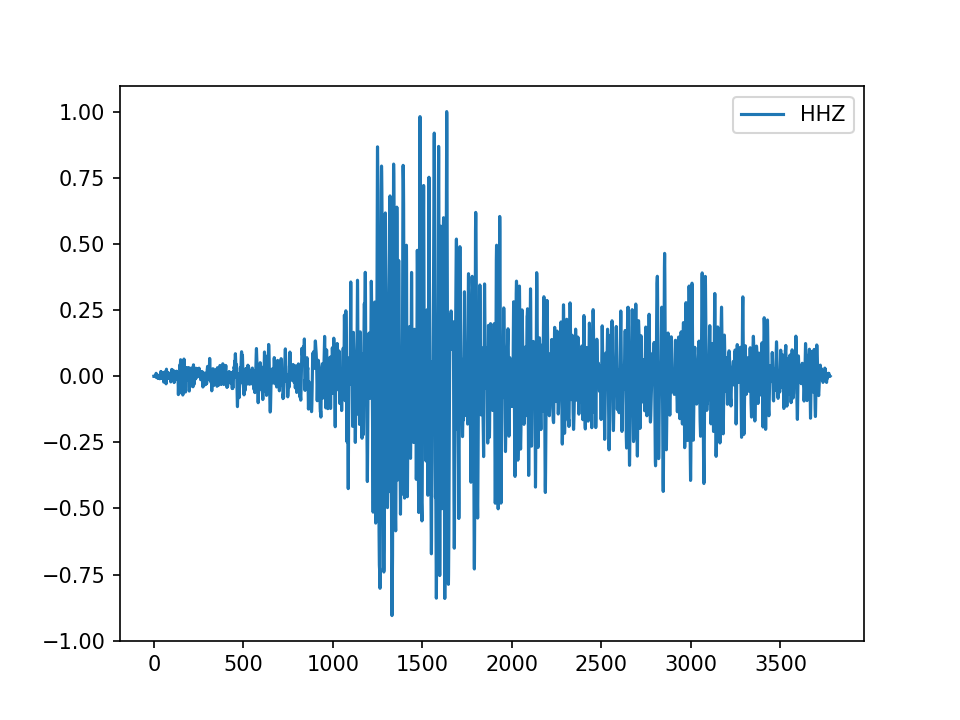

In [24]:
from scipy import signal

st_c = st.copy()
st_c.filter('bandpass', freqmin=0.01, freqmax=0.25)
#st_c.filter('highpass', freq=0.02)
#st_c.select(station='NRA2').plot(equal_scale=False)
plt.figure()
for tr in st_c:
    tr.resample(20.)
    plt.plot(tr.times(), tr.data/tr.data.max(), label=tr.stats.channel)
#corr = signal.correlate(st_c[0].data/st_c[0].data.max(), st_c[1].data/st_c[1].data.max(), mode='same')
#corr = np.correlate(a=st_c[0].data/st_c[0].data.max(), v=st_c[1].data/st_c[1].data.max())
#plt.plot(tr.times(), corr/corr.max())
#plt.title(corr)
plt.legend()